### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

### Data Load, DataLoader

In [2]:
# Transform 정의 (이미지 -> tensor)
transform = transforms.ToTensor()  # [0,1] 범위의 float tensor로 변환

# MNIST 데이터셋 불러오기
train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Train, Val 데이터 나누기 (train_dataset에서)
train_size = int(0.8 * len(train)) # 80% 학습
val_size = len(train) - train_size # 20% 검증

train_dataset, val_dataset = random_split(train, [train_size, val_size])

# DataLoader 연결
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### DNN Model Create

In [3]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten (batch_size, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = DNN()

### Loss Function & Optimizer

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train Model

In [5]:
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # 학습 모드 전환
    model.train()
    train_loss_epoch = 0.0

    for features, targets in train_loader:  # 학습 데이터를 batch_size 단위로 불러오기 
        outputs = model(features) # 순전파
        loss = criterion(outputs, targets) # 손실 계산

        optimizer.zero_grad() # 기울기 초기화
        loss.backward() # 역전파
        optimizer.step() # 파라미터 업데이트

        train_loss_epoch += loss.item() # 손실값 누적

    avg_train_loss = train_loss_epoch / len(train_loader) # epoch당 평균 학습 손실 계산
    train_losses.append(avg_train_loss)

# ======================================================================================================
    
    # 평가 모드 전환 (Dropout, BatchNorm 등을 비활성화)
    model.eval()
    val_loss_epoch = 0.0
    
    with torch.no_grad():
        for features, targets in val_loader:  # 검증 데이터를 batch_size 단위로 불러오기
            outputs = model(features)  # 순전파
            loss = criterion(outputs, targets) # 손실계산
            
            val_loss_epoch += loss.item() # 손실값 누적
            
    avg_val_loss = val_loss_epoch / len(test_loader) # 평균 검증 손실 계산
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")    

Epoch 1/10 - Train Loss: 0.3814, Val Loss: 0.2582
Epoch 2/10 - Train Loss: 0.1624, Val Loss: 0.1827
Epoch 3/10 - Train Loss: 0.1131, Val Loss: 0.1467
Epoch 4/10 - Train Loss: 0.0886, Val Loss: 0.1288
Epoch 5/10 - Train Loss: 0.0688, Val Loss: 0.1164
Epoch 6/10 - Train Loss: 0.0558, Val Loss: 0.1111
Epoch 7/10 - Train Loss: 0.0430, Val Loss: 0.1360
Epoch 8/10 - Train Loss: 0.0368, Val Loss: 0.1064
Epoch 9/10 - Train Loss: 0.0299, Val Loss: 0.1153
Epoch 10/10 - Train Loss: 0.0257, Val Loss: 0.1104


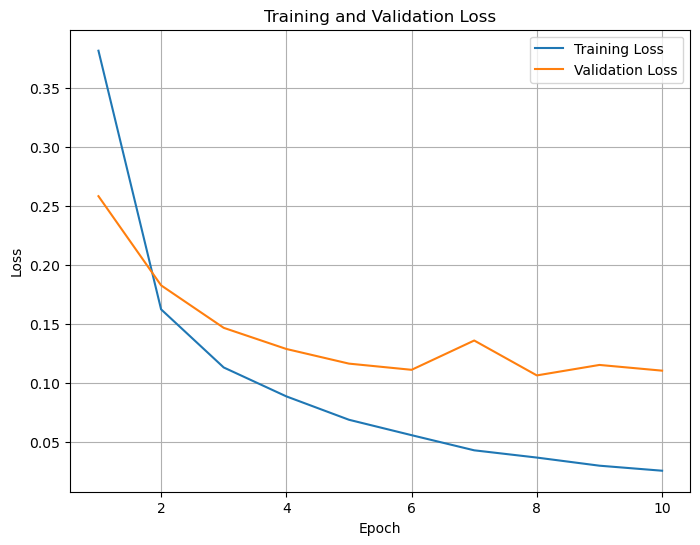

In [6]:
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluation & Test

In [7]:
# 평가 모드 전환
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features, targets in test_loader:  # 테스트 데이터를 미니배치 단위로 불러옴 
        outputs = model(features) # 순전파
        preds = torch.argmax(outputs, dim=1)  # softmax 출력 중 최대 확률을 갖는 클래스로 예측 
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# 평가 지표 출력
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
cm = confusion_matrix(all_labels, all_preds)

print("\n=== Classification Report ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print("Confusion Matrix:")
print(cm)


=== Classification Report ===
Accuracy : 0.9755
Precision: 0.9755
Recall   : 0.9753
F1 Score : 0.9754
Confusion Matrix:
[[ 973    0    0    0    1    0    1    1    4    0]
 [   0 1121    3    4    0    0    2    0    5    0]
 [   7    0 1003    1    3    0    2    7    9    0]
 [   0    1    8  979    0    6    1    3    9    3]
 [   0    1    4    0  959    1    5    1    1   10]
 [   2    0    0   10    2  861    5    2    8    2]
 [   6    2    1    1    4    2  938    1    3    0]
 [   1    8   12    4    1    0    0  992    1    9]
 [   3    1    2    3    2    3    2    3  951    4]
 [   3    4    0    2   13    0    0    2    7  978]]
